In [2]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

#Data Preparation and Exploration

In [3]:
(X_train, y_train),(X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


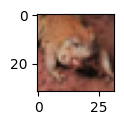

In [4]:
fig = plt.figure(figsize=(1,1))
plt.imshow(X_test[5])

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.1, random_state=101)

In [6]:
X_train.shape, y_train.shape

((45000, 32, 32, 3), (45000, 1))

In [7]:
X_valid.shape, y_valid.shape

((5000, 32, 32, 3), (5000, 1))

In [8]:
X_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1))

In [9]:
y_train[1]

array([7], dtype=uint8)

In [10]:
class_names = ['airplane', 'automobile', 'bird','cat','deer','dog','frog','horse','ship','truck']

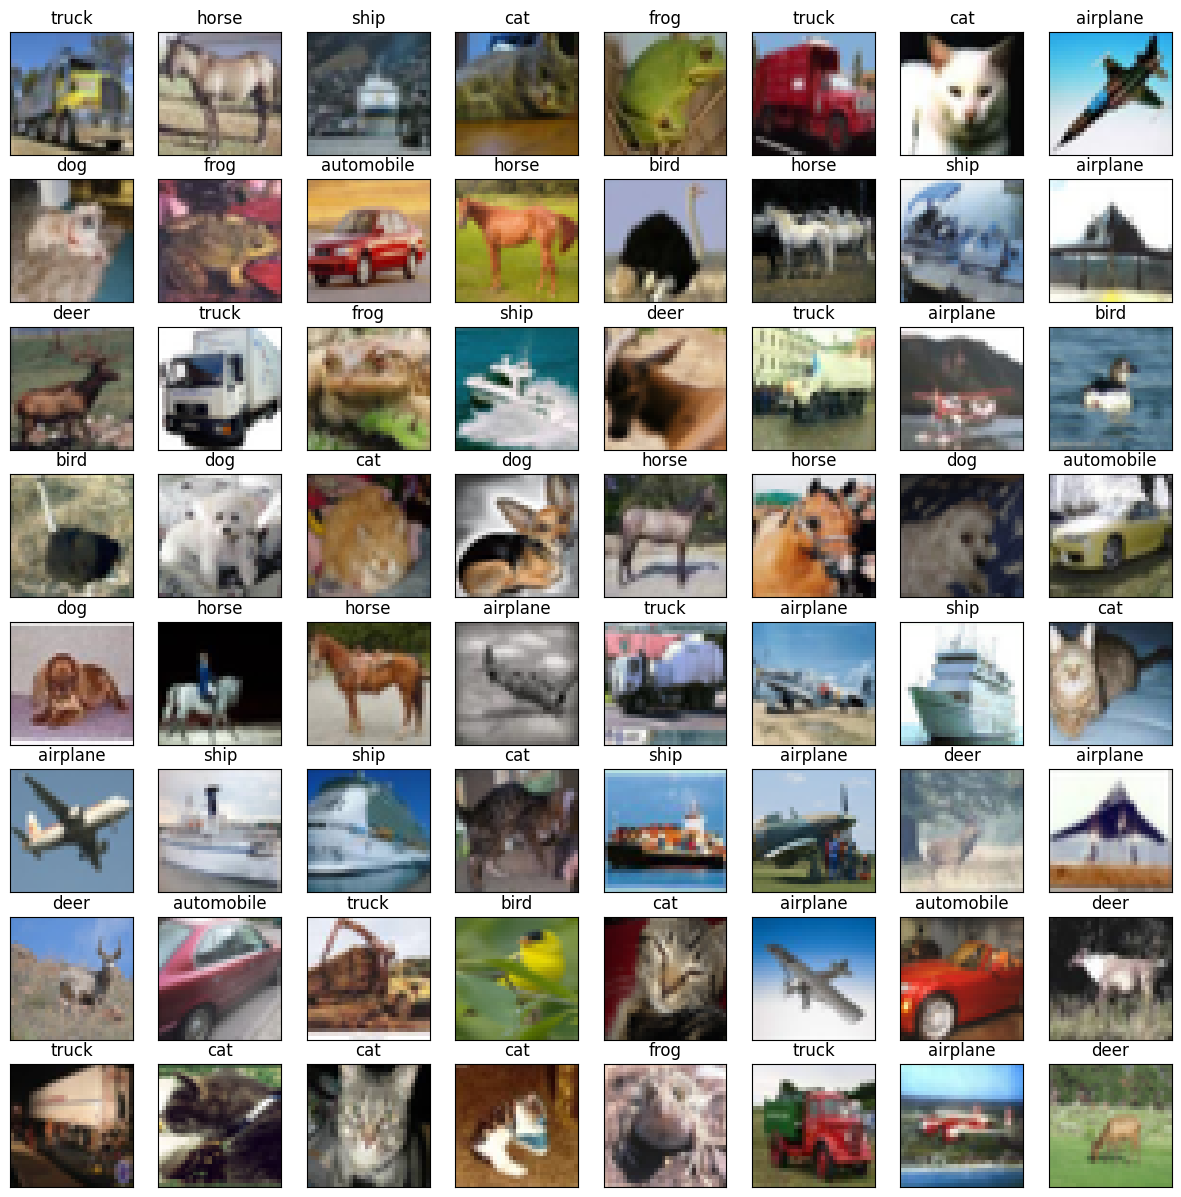

In [11]:
plt.figure(figsize=(15,15))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_train[i])
  plt.title(class_names[y_train[i][0]])

plt.show()

# Data Preprocssing

1. Normalisation of images
2. One hot encoding of Labels
3. Data Augmentation

#### Normalisation

In [ ]:
# Converting pixel values to float32

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Calculate the mean and std of training images
mean = np.mean(X_train)
std = np.std(X_train)

# Normalize the data
X_train = (X_train-mean)/(std+.00000001)
X_test = (X_test-mean)/(std+.00000001)
X_valid = (X_valid-mean)/(std+.00000001)

In [13]:
print(mean)
print(std)

120.68732
64.14855


In [14]:
X_train

array([[[[-0.68103355,  0.05164081,  1.1428579 ],
         [-0.68103355,  0.03605199,  1.1272691 ],
         [-0.68103355,  0.05164081,  1.1272691 ],
         ...,
         [ 0.08281844,  0.14517371,  0.36341715],
         [ 0.56607175,  0.64401585,  0.8934369 ],
         [ 0.86225927,  1.0493251 ,  1.4078678 ]],

        [[-0.6342671 ,  0.09840726,  1.1896244 ],
         [-0.6498559 ,  0.08281844,  1.1740355 ],
         [-0.6498559 ,  0.08281844,  1.1896244 ],
         ...,
         [-0.19778025, -0.13542499,  0.08281844],
         [ 0.1295849 ,  0.2542954 ,  0.6907823 ],
         [ 0.6907823 ,  0.92461455,  1.4702231 ]],

        [[-0.6186783 ,  0.11399607,  1.2208021 ],
         [-0.6186783 ,  0.11399607,  1.1896244 ],
         [-0.6186783 ,  0.11399607,  1.2052132 ],
         ...,
         [-0.49396777, -0.41602367, -0.26013553],
         [-0.1510138 ,  0.03605199,  0.41018358],
         [ 0.26988423,  0.5972494 ,  1.1428579 ]],

        ...,

        [[ 1.1740355 ,  0.84667045,  0

#### One Hot Encoding of Labels

In [15]:
y_train = to_categorical(y_train,10)
y_valid = to_categorical(y_valid,10)
y_test = to_categorical(y_test,10)

#### Data Augmentation

In [16]:
data_generator = ImageDataGenerator(
    rotation_range = 15, #rotate images by up to 15 degree
    width_shift_range = .12, #shift images horizontally by upto 12% of width
    height_shift_range = 0.12,
    horizontal_flip =True,
    zoom_range = 0.1,
    brightness_range = [0.9,1.1],
    shear_range = 10, #Shear intesity (share angle in anti clockwise direction),
    channel_shift_range = 0.1
)

## Model

In [17]:
model = Sequential()

weight_decay = 0.0001 #weight decay for l2 regularization

model.add(Conv2D(filters=32, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay), input_shape = X_train.shape[1:]))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay)))
model.add(BatchNormalization())

#Add first max pooling layer with pool size of 2*2
model.add(MaxPooling2D(pool_size=(2,2)))
#Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))


#Add the third and fourth Conv layers
model.add(Conv2D(filters=64, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay)))
model.add(BatchNormalization())

#Add 2nd max pooling layer with pool size of 2*2
model.add(MaxPooling2D(pool_size=(2,2)))
#Add dropout layer with 0.3 dropout rate
model.add(Dropout(rate=0.3))


model.add(Conv2D(filters=128, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay)))
model.add(BatchNormalization())

#Add 3rd max pooling layer with pool size of 2*2
model.add(MaxPooling2D(pool_size=(2,2)))
#Add dropout layer with 0.4 dropout rate
model.add(Dropout(rate=0.4))


model.add(Conv2D(filters=256, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay)))
model.add(BatchNormalization())


#Add 4th max pooling layer with pool size of 2*2
model.add(MaxPooling2D(pool_size=(2,2)))
#Add dropout layer with 0.5 dropout rate
model.add(Dropout(rate=0.5))


#Flatten the tensor output from the previous layer
model.add(Flatten())

#Add a fully connected layer with softmax activation function
model.add(Dense(10,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,186,346 (4.53 MB)

 Trainable params: 1,184,426 (4.52 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [19]:
# Set the batch size
batch_size =64

epochs = 300 #instead of 150, run this for 300/400 epochs

optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience = 10, min_lr = .00001)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 40, restore_best_weights=True, verbose=1)

model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (X_valid, y_valid),
                              callbacks = [reduce_lr, early_stopping],
                              verbose=2)

Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 - 69s - 99ms/step - accuracy: 0.3341 - loss: 2.3360 - val_accuracy: 0.4320 - val_loss: 1.8257 - learning_rate: 5.0000e-04
Epoch 2/300
704/704 - 48s - 68ms/step - accuracy: 0.4674 - loss: 1.7110 - val_accuracy: 0.5356 - val_loss: 1.3919 - learning_rate: 5.0000e-04
Epoch 3/300
704/704 - 44s - 63ms/step - accuracy: 0.5307 - loss: 1.5115 - val_accuracy: 0.5738 - val_loss: 1.4013 - learning_rate: 5.0000e-04
Epoch 4/300
704/704 - 45s - 63ms/step - accuracy: 0.5758 - loss: 1.3601 - val_accuracy: 0.6082 - val_loss: 1.2016 - learning_rate: 5.0000e-04
Epoch 5/300
704/704 - 44s - 62ms/step - accuracy: 0.6162 - loss: 1.2238 - val_accuracy: 0.6482 - val_loss: 1.2180 - learning_rate: 5.0000e-04
Epoch 6/300
704/704 - 44s - 63ms/step - accuracy: 0.6450 - loss: 1.1410 - val_accuracy: 0.6986 - val_loss: 0.9646 - learning_rate: 5.0000e-04
Epoch 7/300
704/704 - 43s - 62ms/step - accuracy: 0.6690 - loss: 1.0688 - val_accuracy: 0.7410 - val_loss: 0.8518 - learning_rate: 5.0000e-04
Epoch 8/300
704/70

## Visualizing the Learning Curves

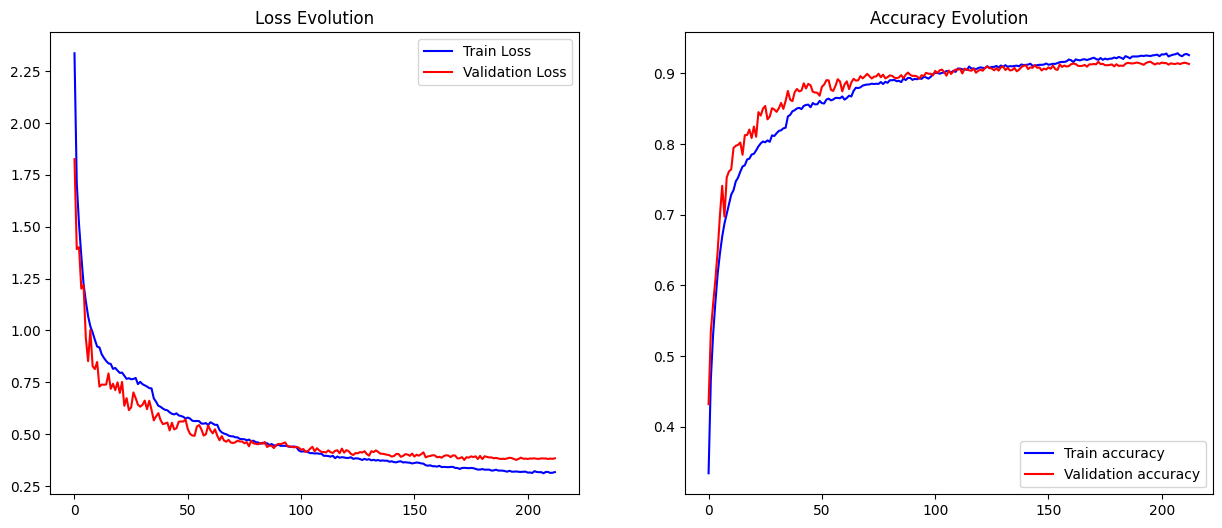

In [20]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(model.history.history['loss'], label = 'Train Loss', color = 'blue')
plt.plot(model.history.history['val_loss'], label = 'Validation Loss', color = 'red')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1,2,2)
plt.plot(model.history.history['accuracy'], label = 'Train accuracy', color = 'blue')
plt.plot(model.history.history['val_accuracy'], label = 'Validation accuracy', color = 'red')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

## Evaluating the Optimal Model on Test Data

In [21]:
test_loss, test_acc = model.evaluate(X_test,y_test, verbose = 1)

print(f'Test Accuracy : {test_acc}\nTestLoss: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9046 - loss: 0.4212
Test Accuracy : 0.9053999781608582
TestLoss: 0.4173518121242523


# performance on an out of Dataset image

In [34]:
url = 'https://naturealberta.ca/wp-content/uploads/2025/04/6.-Tree-Swallow-NICK-CARTER-1536x1340.jpg'
#'https://wildjolie.com/cdn/shop/articles/Do_Horses_Have_Horns.jpg?v=1741247407&width=1780'
reps = urllib.request.urlopen(url)
image = np.asarray(bytearray(reps.read()),dtype='uint8')
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert the image from bgr to rgb

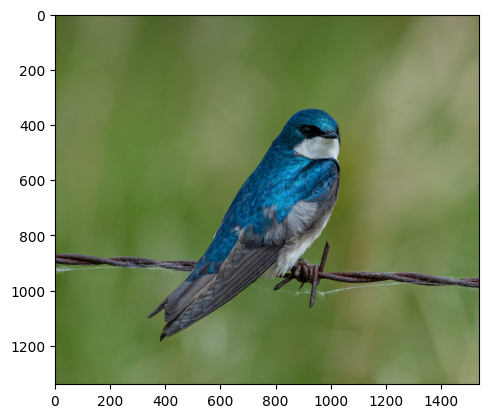

In [35]:
plt.imshow(image)
plt.show()

In [36]:
image.shape

(1340, 1536, 3)

In [37]:
image = cv2.resize(image, (32,32))

#normalize the image
image = (image-mean)/(std+0.000001)

#Add an exyra dimension because the model expects a batch of images
image = image.reshape((1,32,32,3))

In [38]:
predict = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [39]:
predict

array([[1.3326778e-01, 1.4242431e-08, 8.6276883e-01, 1.6524584e-04,
        2.8592301e-06, 3.6987131e-03, 3.1236807e-05, 6.1137529e-05,
        1.1553017e-06, 3.0586725e-06]], dtype=float32)

In [40]:
print(f'The predicted class: {class_names[predict.argmax()]}')

The predicted class: bird


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
save_path = '/content/drive/My Drive/saved_models/my_cnn_model.h5'

In [32]:
model.save(save_path)
# model.save('my_cnn_model')

In [33]:
# model.save('my_cnn_model.h5')

In [42]:
frog = 'https://www.britannica.com/animal/frog'

url = 'https://cdn.mos.cms.futurecdn.net/39CUYMP8vJqHAYGVzUghBX-1200-80.jpg'
#'https://wildjolie.com/cdn/shop/articles/Do_Horses_Have_Horns.jpg?v=1741247407&width=1780'
reps = urllib.request.urlopen(url)
image = np.asarray(bytearray(reps.read()),dtype='uint8')
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert the image from bgr to rgb

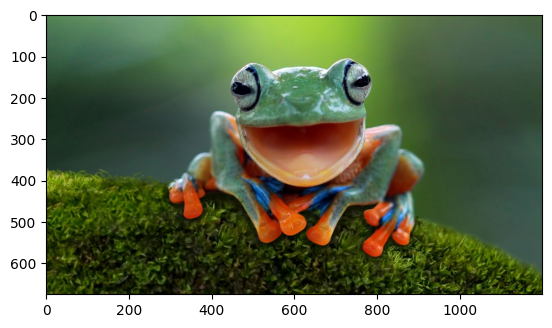

In [43]:
plt.imshow(image)
plt.show()

In [44]:
image.shape

(675, 1200, 3)

In [45]:
image = cv2.resize(image, (32,32))

#normalize the image
image = (image-mean)/(std+0.000001)

#Add an exyra dimension because the model expects a batch of images
image = image.reshape((1,32,32,3))

In [46]:
predict = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [47]:
print(f'The predicted class: {class_names[predict.argmax()]}')

The predicted class: frog


In [55]:
url = 'https://5.imimg.com/data5/SELLER/Default/2022/5/GY/FG/QX/2036879/21feet-full-truck-transportation-service.png'
reps = urllib.request.urlopen(url)
image = np.asarray(bytearray(reps.read()),dtype='uint8')
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert the image from bgr to rgb

<function matplotlib.pyplot.show(close=None, block=None)>

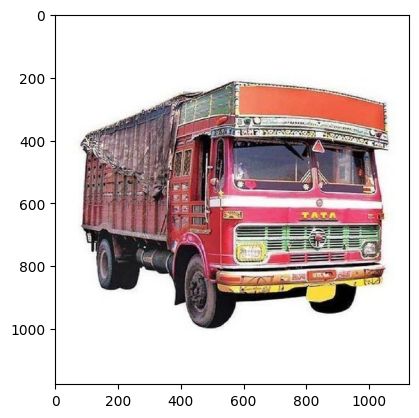

In [56]:
plt.imshow(image)
plt.show

In [57]:
image.shape

(1176, 1128, 3)

In [58]:
image = cv2.resize(image, (32,32))

#normalize the image
image = (image-mean)/(std+0.000001)

#Add an exyra dimension because the model expects a batch of images
image = image.reshape((1,32,32,3))

In [59]:
predict = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [60]:
print(f'The predicted class: {class_names[predict.argmax()]}')

The predicted class: truck


In [61]:
url = 'https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=0.752xw:1.00xh;0.175xw,0&resize=1200:*'
reps = urllib.request.urlopen(url)
image = np.asarray(bytearray(reps.read()),dtype='uint8')
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert the image from bgr to rgb

<function matplotlib.pyplot.show(close=None, block=None)>

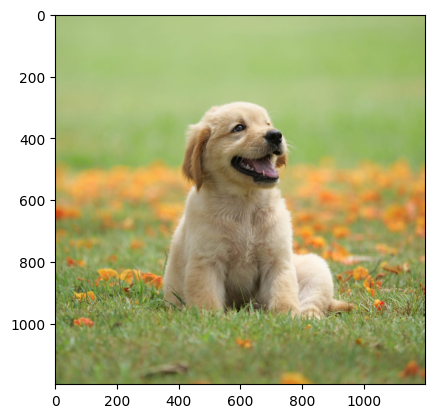

In [62]:
plt.imshow(image)
plt.show

In [63]:
image = cv2.resize(image, (32,32))

#normalize the image
image = (image-mean)/(std+0.000001)

#Add an exyra dimension because the model expects a batch of images
image = image.reshape((1,32,32,3))

In [64]:
predict = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [65]:
print(f'The predicted class: {class_names[predict.argmax()]}')

The predicted class: dog
